In [611]:
%matplotlib inline

In [612]:
import numpy as np
import time

## Arguments

In [613]:
from types import SimpleNamespace

In [614]:
# Segmentation 1
d = dict()

# d['gs_path'] = 'gs://neuroglancer/kisuk/SNEMI3D/train/models/kasthuri11/superhuman/direct/long/aug4/mip0/bce/depth4_patch160-20/iter_200000/fov256-20/static/aff'
# d['gs_path'] = 'gs://neuroglancer/kisuk/SNEMI3D/train/models/superhuman/aug3-long/iter_330000/fov160-32/static/aug16/aff'
d['gs_path'] = 'gs://neuroglancer/kisuk/SNEMI3D/train/models/superhuman/aug3-long/iter_330000/fov160-32/static/crop_x512_y512_z100/aggl'
# d['gs_path'] = 'gs://neuroglancer/kisuk/SNEMI3D/train/models/kasthuri11/snemi3d/metric/edge/aug4/mip1/w32d3/gn32/p160-20/myelin0/vec30/vec100_mye1_hybrid64-32-16-8/iter_530000/mip0/fov160-20/aff'
d['dtype']   = 'uint32'
d['mip']     = 0
d['begin']   = (256,256,0)
d['end']     = None
d['center']  = None
d['size']    = (512,512,100)
d['cache']   = False
d['parallel'] = 8

seg1 = SimpleNamespace(**d)

In [615]:
# Segmentation 2 (ground truth)
d = dict()

# d['gs_path'] = 'gs://neuroglancer/kisuk/SNEMI3D/train/seg'
d['gs_path'] = 'gs://neuroglancer/kisuk/SNEMI3D/train/crop_x512_y512_z100/seg'
d['dtype']   = 'uint32'
d['mip']     = 0
d['begin']   = (256,256,0) 
d['end']     = None
d['center']  = None
d['size']    = (512,512,100)
d['cache']   = False
d['parallel'] = 8

seg2 = SimpleNamespace(**d)

In [616]:
# Segmentation 3 (myelin)
d = dict()

d['gs_path'] = 'gs://neuroglancer/kisuk/SNEMI3D/train/models/kasthuri11/snemi3d/metric/edge/aug4/mip1/w32d3/gn32/p160-20/myelin0/vec30/vec100_mye1_hybrid64-32-16-8/iter_530000/mip0/fov160-20/mye'
d['dtype']   = 'float32'
d['mip']     = 0
d['begin']   = (256,256,0) 
d['end']     = None
d['center']  = None
d['size']    = (512,512,100)
d['cache']   = False
d['parallel'] = 8

seg3 = SimpleNamespace(**d)

## CloudVolume

In [617]:
import cloudvolume as cv
from cloudvolume.lib import Vec, Bbox

In [618]:
def cutout(opt, dtype='uint32'):
    print(opt.gs_path)

    # CloudVolume
    cvol = cv.CloudVolume(opt.gs_path, mip=opt.mip, cache=opt.cache,
                          fill_missing=True, parallel=opt.parallel)

    # Cutout
    offset0 = cvol.mip_voxel_offset(0)
    if opt.center is not None:
        assert opt.size is not None
        opt.begin = tuple(x - (y//2) for x, y in zip(opt.center, opt.size))
        opt.end = tuple(x + y for x, y in zip(opt.begin, opt.size))
    else:
        if not opt.begin:
            opt.begin = offset0
        if not opt.end:
            if not opt.size:
                opt.end = offset0 + cvol.mip_volume_size(0)
            else:
                opt.end = tuple(x + y for x, y in zip(opt.begin, opt.size))
    sl = [slice(x,y) for x, y in zip(opt.begin, opt.end)]
    print('begin = {}'.format(opt.begin))
    print('end = {}'.format(opt.end))

    # Coordinates
    print('mip 0 = {}'.format(sl))
    sl = cvol.slices_from_global_coords(sl)
    print('mip {} = {}'.format(opt.mip, sl))
    cutout = cvol[sl]

    # Transpose & squeeze
    cutout = cutout.transpose([3,2,1,0])
    cutout = np.squeeze(cutout).astype(dtype)
    return cutout

In [619]:
# Segmentation 1
seg1 = cutout(seg1, dtype=seg1.dtype)

gs://neuroglancer/kisuk/SNEMI3D/train/models/superhuman/aug3-long/iter_330000/fov160-32/static/crop_x512_y512_z100/aggl
begin = (256, 256, 0)
end = (768, 768, 100)
mip 0 = [slice(256, 768, None), slice(256, 768, None), slice(0, 100, None)]
mip 0 = [slice(256, 768, 1), slice(256, 768, 1), slice(0, 100, 1)]


Downloading:   0%|          | 0/16 [00:00<?, ?it/s]









In [620]:
# Segmentation 2
seg2 = cutout(seg2, dtype=seg2.dtype)

gs://neuroglancer/kisuk/SNEMI3D/train/crop_x512_y512_z100/seg
begin = (256, 256, 0)
end = (768, 768, 100)
mip 0 = [slice(256, 768, None), slice(256, 768, None), slice(0, 100, None)]
mip 0 = [slice(256, 768, 1), slice(256, 768, 1), slice(0, 100, 1)]


Downloading:   0%|          | 0/16 [00:00<?, ?it/s]









In [621]:
# # Segmentation 3
# seg3 = cutout(seg3, dtype=seg3.dtype)

In [622]:
import skimage.measure as measure
import segascorus as sc

seg2 = measure.label(seg2).astype('uint32')
result = sc.score(seg1, seg2)

Finding overlap matrix...
Completed in 1.874409 seconds
Calculating Rand F-Score...
Completed in 0.002600 seconds
Calculating Variation of Information...
Completed in 0.004070 seconds

Rand F-Score Full: 0.9795256798545436
Rand F-Score Merge: 0.9855289827314548
Rand F-Score Split: 0.9735950718277249
Variation of Information Full: 0.2750774110865848
Variation of Information Merge: 0.1095373312821934
Variation of Information Split: 0.1655400798043914


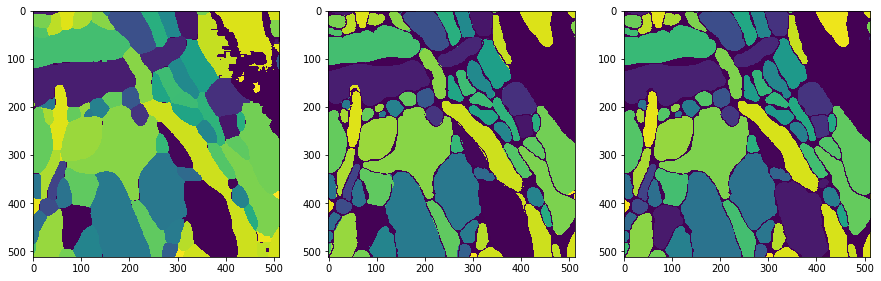

In [625]:
seg_1 = seg1
seg_2 = np.copy(seg_1)
seg_2[seg2==0] = 0

z = 70
plt.figure(figsize=(15,15))
plt.subplot(1,3,1)
plt.imshow(seg_1[z,:,:])
plt.subplot(1,3,2)
plt.imshow(seg_2[z,:,:])
plt.subplot(1,3,3)
plt.imshow(seg2[z,:,:])
plt.show()

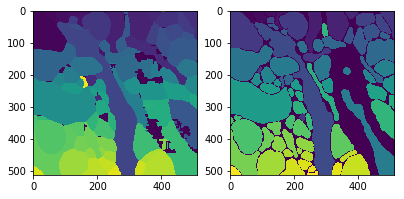

In [598]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,10))
plt.subplot(1,3,1)
# plt.imshow(seg1[0,1,:,:], cmap='gray')
plt.imshow(seg1[1,:,:])
plt.subplot(1,3,2)
plt.imshow(seg2[1,:,:])
# plt.subplot(1,3,3)
# plt.imshow(seg3[1,:,:], cmap='gray')
plt.show()

In [599]:
# import torch
# import torch.nn as nn
# import torch.nn.functional as F

# aff = F.upsample_bilinear(torch.from_numpy(seg1), scale_factor=(2,2)).numpy()

In [503]:
# import skimage.measure as measure

# aff = seg1
# seg2 = measure.label(seg2).astype('uint32')

In [504]:
# mye = 1.0 - seg3
# xy = np.minimum((aff[0,...] + aff[1,...])/2, mye)
# aff[0,...] = xy
# aff[1,...] = xy
# aff[2,...] = np.minimum(aff[2,...],xy)

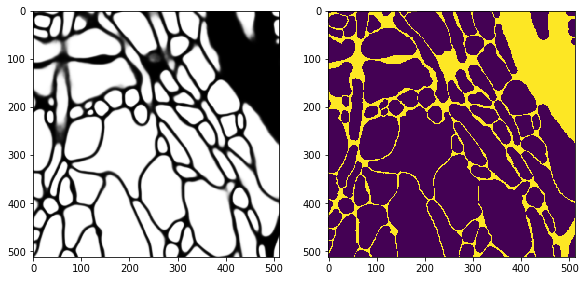

In [506]:
z = 69 
plt.figure(figsize=(15,15))
plt.subplot(1,3,1)
plt.imshow(aff[0,z,:,:], cmap='gray')
plt.subplot(1,3,2)
plt.imshow(seg2[z,:,:]==0)
# plt.subplot(1,3,3)
# plt.imshow(seg3[z,:,:], cmap='gray')
plt.show()

## Grid Search

In [520]:
from collections import OrderedDict
import datatools
import segascorus as sc

In [521]:
results = OrderedDict()
metric = "Variation of Information Full"
cmp_func = np.argmin

In [522]:
# 1st pass
print("1st pass...")
for t in np.arange(0.1,1,0.1):
# for t in np.arange(0.9,1,0.01):
    print("Threshold = {:.3f}".format(t))
    seg1 = datatools.get_segmentation(aff, t)
    seg1 = datatools.dilate_segmentation(seg1, k=1024).astype('uint32')
    results[t] = sc.score(seg1, seg2)
    print("")

1st pass...
Threshold = 0.100
Finding overlap matrix...
Completed in 1.755718 seconds
Calculating Rand F-Score...
Completed in 0.000798 seconds
Calculating Variation of Information...
Completed in 0.000515 seconds

Rand F-Score Full: 0.04335389731635107
Rand F-Score Merge: 0.02215730245217401
Rand F-Score Split: 0.9998936485155985
Variation of Information Full: 6.178140580242128
Variation of Information Merge: 6.176383124966853
Variation of Information Split: 0.0017574552752748964

Threshold = 0.200
Finding overlap matrix...
Completed in 1.687098 seconds
Calculating Rand F-Score...
Completed in 0.001257 seconds
Calculating Variation of Information...
Completed in 0.000801 seconds

Rand F-Score Full: 0.06754755015378629
Rand F-Score Merge: 0.03495943979288342
Rand F-Score Split: 0.9958230522132854
Variation of Information Full: 4.52382123717631
Variation of Information Merge: 4.484993364022684
Variation of Information Split: 0.03882787315362476

Threshold = 0.300
Finding overlap matrix.

In [523]:
# Optimal threshold
idx = cmp_func([v[metric] for v in results.values()])
opt_thresh = list(results.items())[idx][0]
print("Optimal threshold = {}".format(opt_thresh))

Optimal threshold = 0.7000000000000001


In [524]:
# 2nd pass
print("2nd pass...")
for d in [-0.05,0.05]:
# for d in [-0.005,0.005]:
    t = opt_thresh + d
    print("Threshold = {:.3f}".format(t))
    seg1 = datatools.get_segmentation(aff, t)
    seg1 = datatools.dilate_segmentation(seg1, k=1024).astype('uint32')
    results[t] = sc.score(seg1, seg2)
    print("")

2nd pass...
Threshold = 0.650
Finding overlap matrix...
Completed in 1.238482 seconds
Calculating Rand F-Score...
Completed in 0.001342 seconds
Calculating Variation of Information...
Completed in 0.001014 seconds

Rand F-Score Full: 0.9789005261391941
Rand F-Score Merge: 0.9841871056180805
Rand F-Score Split: 0.9736704371420813
Variation of Information Full: 0.29224361418110956
Variation of Information Merge: 0.12722785501816347
Variation of Information Split: 0.16501575916294609

Threshold = 0.750
Finding overlap matrix...
Completed in 1.260944 seconds
Calculating Rand F-Score...
Completed in 0.000878 seconds
Calculating Variation of Information...
Completed in 0.000602 seconds

Rand F-Score Full: 0.9781204967148712
Rand F-Score Merge: 0.9834898299022996
Rand F-Score Split: 0.9728094726172577
Variation of Information Full: 0.30651341181396097
Variation of Information Merge: 0.13293793012040436
Variation of Information Split: 0.1735754816935566



In [525]:
# Optimal threshold
idx = np.argmin([v[metric] for v in results.values()])
opt_thresh = list(results.items())[idx][0]
print("Optimal threshold = {}".format(opt_thresh))

Optimal threshold = 0.65


In [526]:
# 3rd pass
print("3rd pass...")
for d in [-0.04,-0.03,-0.02,-0.01,0.01,0.02,0.03,0.04]:
# for d in [-0.004,-0.003,-0.002,-0.001,0.001,0.002,0.003,0.004]:
    t = opt_thresh + d
    print("Threshold = {:.3f}".format(t))
    seg1 = datatools.get_segmentation(aff, t)
    seg1 = datatools.dilate_segmentation(seg1, k=1024).astype('uint32')
    results[t] = sc.score(seg1, seg2)
    print("")

3rd pass...
Threshold = 0.610
Finding overlap matrix...
Completed in 1.286592 seconds
Calculating Rand F-Score...
Completed in 0.001352 seconds
Calculating Variation of Information...
Completed in 0.001017 seconds

Rand F-Score Full: 0.9750822731012099
Rand F-Score Merge: 0.9762713096292309
Rand F-Score Split: 0.9738961293920545
Variation of Information Full: 0.3124415476993152
Variation of Information Merge: 0.150395532180449
Variation of Information Split: 0.1620460155188662

Threshold = 0.620
Finding overlap matrix...
Completed in 1.271287 seconds
Calculating Rand F-Score...
Completed in 0.001600 seconds
Calculating Variation of Information...
Completed in 0.001164 seconds

Rand F-Score Full: 0.9750442952783147
Rand F-Score Merge: 0.9762279778662917
Rand F-Score Split: 0.9738634796593453
Variation of Information Full: 0.3131480521943759
Variation of Information Merge: 0.1507826093623422
Variation of Information Split: 0.16236544283203372

Threshold = 0.630
Finding overlap matrix...


In [527]:
# Optimal threshold
idx = np.argmin([v[metric] for v in results.values()])
opt_thresh = list(results.items())[idx][0]
print("Optimal threshold = {}".format(opt_thresh))

Optimal threshold = 0.65


In [528]:
from collections import OrderedDict

results = OrderedDict(sorted(results.items(), key=lambda x: x[0]))

In [529]:
results[opt_thresh]

{'Rand F-Score Full': 0.9789005261391941,
 'Rand F-Score Merge': 0.9841871056180805,
 'Rand F-Score Split': 0.9736704371420813,
 'Variation of Information Full': 0.29224361418110956,
 'Variation of Information Merge': 0.12722785501816347,
 'Variation of Information Split': 0.16501575916294609}

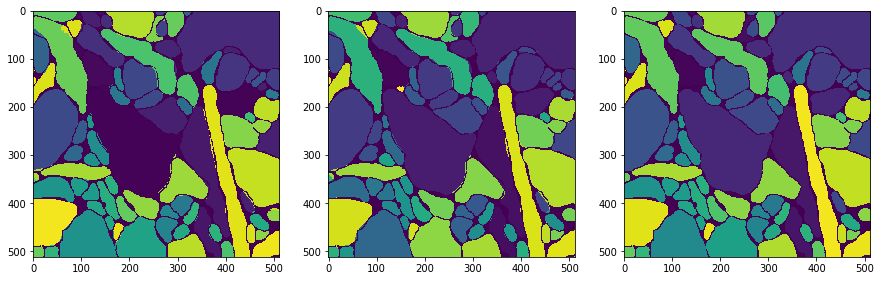

In [610]:
# seg_1 = datatools.get_segmentation(aff, opt_thresh)
# seg_2 = datatools.dilate_segmentation(seg_1, k=1024).astype('uint32')
# seg_2[seg2==0] = 0

seg_1 = seg1
seg_1[seg2==0] = 0

z = 30
plt.figure(figsize=(15,15))
plt.subplot(1,3,1)
plt.imshow(seg_1[z,:,:])
plt.subplot(1,3,2)
plt.imshow(seg_2[z,:,:])
plt.subplot(1,3,3)
plt.imshow(seg2[z,:,:])
plt.show()

## Visualize

### Rand score

In [40]:
metric = "Rand F-Score"
x = [v[metric + " Split"] for v in results.values()]
y = [v[metric + " Merge"] for v in results.values()]
# sorted(zip(x,y), key=lambda x: x[0])

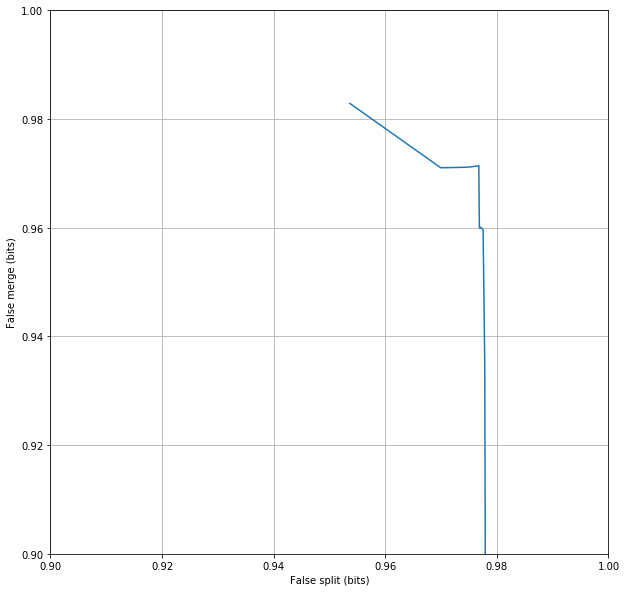

In [42]:
plt.figure(figsize=(10,10))
plt.plot(x,y)
plt.axis([0.9, 1, 0.9, 1])
plt.xlabel('False split (bits)')
plt.ylabel('False merge (bits)')
plt.grid(True)
plt.show()

### Variation of Information

In [34]:
metric = "Variation of Information"
x = [v[metric + " Split"] for v in results.values()]
y = [v[metric + " Merge"] for v in results.values()]
# sorted(zip(x,y), key=lambda x: x[0])

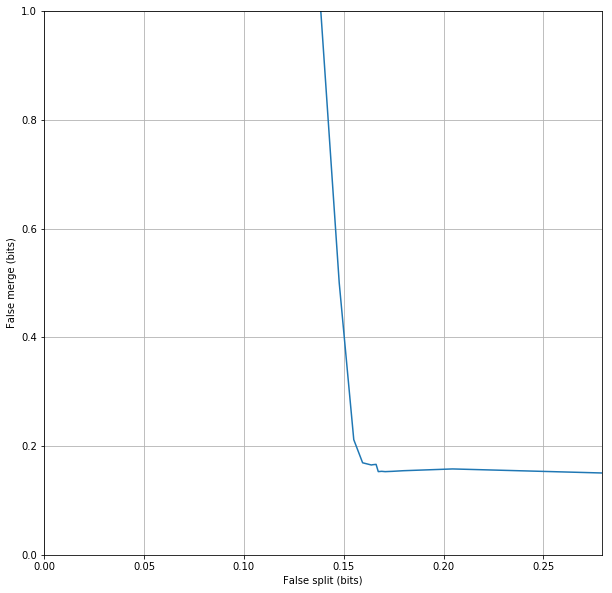

In [39]:
plt.figure(figsize=(10,10))
plt.plot(x,y)
plt.axis([0, max(x), 0, 1])
plt.xlabel('False split (bits)')
plt.ylabel('False merge (bits)')
plt.grid(True)
plt.show()

## VI breakdown